In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

## Data Consolidation
Run the consolidation function code chunks, and then run below chunk to get consolidated user-specific, user-unspecific, and labeled data scraped from Spotify API

In [2]:
user1 = pd.read_csv("01_Data/user_tracks_Benedict.csv", index_col = 0)
user2 = pd.read_csv("01_Data/user_tracks_Yannik.csv", index_col = 0)
user3 = pd.read_csv("01_Data/user_tracks_Julian.csv", index_col = 0)
user4 = pd.read_csv("01_Data/user_tracks_Glory.csv", index_col = 0)
user4_labeled = pd.read_csv("01_Data/user_tracks_Glory_labeled.csv", index_col = 0)
glbl = pd.read_csv("01_Data/user_unspecific_tracks.csv", index_col = 0)

In [3]:
def assign_label(df, df_label):
    '''
    Takes dataframe and adds labels to it to later filter for users.
    '''
    df["df_label"] = df_label
    return df
    
def drop_dupes(df):
    '''
    Takes dataframe and drops duplicates.
    '''
    df = df.drop_duplicates(subset = ["uri"])
    df = df.reset_index(drop=True)
    return df

def concat_dfs(lst):
    '''
    Takes list of dataframes and concats them.
    '''
    df = pd.concat(lst)
    return df

In [4]:
user_dct = {"user1": "Benedict", "user2": "Yannik", "user3": "Julian", "user4": "Glory"}

In [5]:
assign_label(user1, "user1")
assign_label(user2, "user2")
assign_label(user3, "user3")
assign_label(user4, "user4")
assign_label(user4_labeled, "user4")
assign_label(glbl, "global")
glbl = drop_dupes(glbl)
dat = concat_dfs([user1, user2, user3, user4, user4_labeled, glbl])

# this step is optional
# dat.to_csv("01_Data/dat_raw.csv")

## Data Cleaning and Feature Engineering
Run the cleaning functions code chunk, and then run below chunk to get cleaned and partially feature engineered data

In [6]:
def drop_cols(df):
    '''
    Takes a dataframe and returns a dataframe with unwanted columns dropped.
    '''  
    df.drop(['tempo_confidence', 'overall_key_confidence', 'mode_confidence', 'time_signature_confidence',
             'section_tempo_confidences', 'section_keys', 'section_key_confidences', 'section_modes',
             'section_mode_confidences', 'section_time_signatures', 'section_time_signature_confidences'],
            axis = 1, inplace = True)
    df = df.reset_index(drop=True)
    return df

def drop_none(df):
    '''
    Takes a dataframe and returns a datafrmae with none values in audio features dropped.
    '''
    df.replace('None', np.nan, inplace=True)
    df = df.dropna(subset = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo", "overall_key", "mode", 
                             "time_signature", "num_of_sections", "num_of_keys", "num_of_modes", "num_of_time_signatures", 'section_durations', 'section_loudnesses', 'section_tempos'])
    df = df.reset_index(drop=True)
    return df

def bin_album_label(df, drop = True):
    '''
    Takes a dataframe and returns a dataframe with a new column 'album_label_category'.
    Categorizes album_label into 'big label' (>= 80 songs produced by label), 'medium label' (<80 and >=11 songs produced by label), and 'small label' (<11 songs produced by label).
    If drop = False, then the album_label and album_label_count (a feature created in this function) columns are not dropped.
    '''
    album_label_counts = df.groupby(['album_label']).count()['album_uri']
    album_label_counts.name = 'album_label_count'

    df = df.join(album_label_counts, on = 'album_label')
     
    def categorize_album_label(obs):
        if obs >= 80:
            return 'big_label'
        if 80 > obs >= 11:
            return 'medium_label'
        else:
            return 'small_label'

    df['album_label_category'] = df['album_label_count'].apply(categorize_album_label)
    
    if drop == True:
        df = df.drop(['album_label', 'album_label_count'], axis = 1)
    
    return df

def transform_date(df):
    '''
    Takes dataframe, returns dataframe with new col 'release_year_from_2020'.
    Drops 'album_release_date'.
    'release_year_from_2020' = 2020 - year album was released
    '''
    df['release_year_from_2020'] = df['album_release_date'].str.extract(r'(\d\d\d\d)', expand = False)
    df['release_year_from_2020'] = df['release_year_from_2020'].apply(lambda x: 2020 - int(x))
    df.drop('album_release_date', axis = 1, inplace = True)
    
    return df

def convert_duration_to_min(df):
    '''
    Converts miliseconds into minutes
    '''
    df["duration_minutes"] = df["duration_ms"]/60000
    df.drop(columns="duration_ms", inplace=True)
    return df

def extract_section_vars(df):
    '''
    Takes dataframe, returns dataframe with section variables turned into corresponding min, max, and variance columns.
    Section variable is dropped, and 3 new columns created in its stead.
    Drops rows that have 'None' or empty lists
    '''
    section_vars = ['section_durations', 'section_loudnesses', 'section_tempos']
    
    for var in section_vars:
        df[var + '_variance'] = [np.var(eval(i)) if (eval(i) != 'None') & (len(eval(i)) > 0) else np.nan for i in df[var].values]
        df[var + '_min'] = [np.min(eval(i)) if (eval(i) != 'None') & (len(eval(i)) > 0) else np.nan for i in df[var].values]
        df[var + '_max'] = [np.max(eval(i)) if (eval(i) != 'None') & (len(eval(i)) > 0) else np.nan for i in df[var].values]
        
        df.drop(var, axis = 1, inplace = True)
    
    df = df.dropna(subset = ["section_durations_variance", "section_durations_min", "section_durations_max", 
                             "section_loudnesses_variance", "section_loudnesses_min", "section_loudnesses_max", 
                             "section_tempos_variance", "section_tempos_min", "section_tempos_max"])
    df = df.reset_index(drop=True)
    return df

def convert_to_numeric(df):
    df[["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", 
       "valence", "tempo", "overall_key",  "mode", "time_signature", "num_of_sections", "num_of_keys", 
       "num_of_modes", "num_of_time_signatures"
      ]] = df[["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", 
                  "speechiness", "valence", "tempo", "overall_key",  "mode", "time_signature", "num_of_sections", 
                  "num_of_keys",  "num_of_modes", "num_of_time_signatures"
              ]].apply(pd.to_numeric, errors="coerce")
    
    return df

In [7]:
dat = pd.read_csv('01_Data/dat_raw.csv', index_col = 0)

dat = drop_cols(dat)
dat = drop_none(dat)
dat = bin_album_label(dat, drop = True)
dat = transform_date(dat)
dat = convert_duration_to_min(dat)
dat = convert_to_numeric(dat)
dat = extract_section_vars(dat)

/Users/juliankleindiek/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (48,49,50) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Genre
We need to find a way to aggregate genres. Hence we convert the strings into numerical values with TfidfVectorizer and then run TruncatedSVD to reduce dimensions and find common clusters with K-Means

In [8]:
# create space-separated string cloumn for genre
dat["genre_string"] = [" ".join(eval(i)) for i in dat["genre"]]

In [9]:
# initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# fit vecotrizer
vectorizer.fit(dat["genre_string"].values)

# transform
genres_vectorized = vectorizer.transform(dat["genre_string"].values)

In [10]:
# define function to plot elbow method
def plot_inertia(array, start=1, end=10):
    
    # claculate interias
    inertia = []
    ks = range(start, end+1)
    for k in ks:
        model = KMeans(n_clusters = k, random_state = 0).fit(array)
        inertia.append(model.inertia_)
        
    # plot interias
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(ks, inertia, '-o')
    ax.set_title('The elbow method')
    ax.set_ylabel('Inertia')
    ax.set_xlabel('Number of clusters')
    plt.show()
    
    # return plot
    return ax

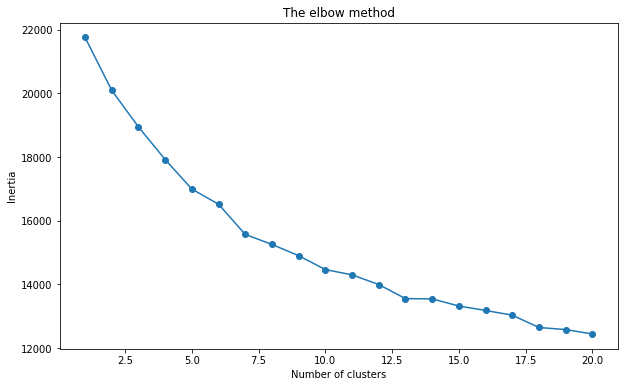

In [52]:
# apply function on vectorized data
inertia = plot_inertia(genres_vectorized, 1, 20)

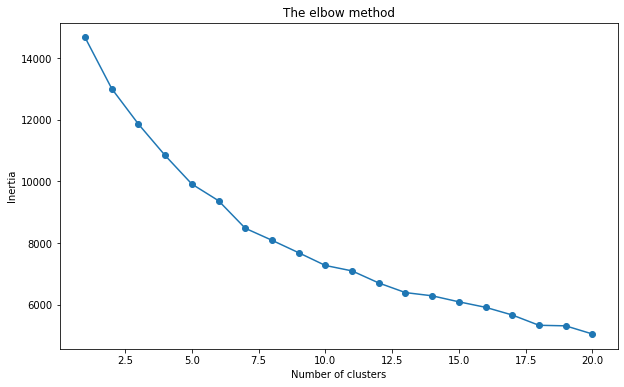

In [11]:
# initialize TruncatedSVD
svd = TruncatedSVD(n_components=40, random_state = 3)

# fit svd and transform data
genres_vectorized_svd = svd.fit_transform(genres_vectorized)

# apply function on truncated data
inertia = plot_inertia(genres_vectorized_svd, 1, 20)

The elbow method reults in similar shapes for both the dimensionality-reduced and original data. The runtime of the dimensionality-reduced data is significantly faster and since the results are similar we choose to create labels for the genres using the reduced data. The ideal number of clusters appears to be 13.

In [11]:
# initialize TruncatedSVD
svd = TruncatedSVD(n_components=40, random_state = 3)

# fit svd and transform data
genres_vectorized_svd = svd.fit_transform(genres_vectorized)

# run K-Mens on original data with n_clusters = 13
kmeans = KMeans(n_clusters = 13, random_state = 3).fit(genres_vectorized_svd)

# create cluster labels
labels = kmeans.predict(genres_vectorized_svd)

# write clustered genres to data frame
dat["genre_clustered"] = labels

In [12]:
# investigate cluster
c = 7
dat[["artist_name", "genre_string", "genre_clustered"]][dat["genre_clustered"] == c]

,artist_name,genre_string,genre_clustered
3776,Christian Nodal,regional mexican pop,7
3783,Kanales,corrido regional mexican pop,7
3832,Banda Los Recoditos,banda grupera regional mexican regional mexica...,7
3878,Fuerza Regida,regional mexican pop,7
4063,Banda Sinaloense MS de Sergio Lizárraga,banda norteno regional mexican,7
...,...,...,...
23437,Fuerza Regida,regional mexican pop,7
23702,Fuerza Regida,regional mexican pop,7
24060,Espinoza Paz,banda grupera norteno ranchera regional mexican,7
24080,Joan Sebastian,banda grupera norteno regional mexican,7


In [13]:
# create dictionary with clusters
cluster_dct = {0:"hip hop", 
               1:"indie", 
               2:"misc", 
               3:"baroque classic", 
               4:"classical", 
               5:"country", 
               6:"pop", 
               7:"mexican",
               8:"alternative metal/rock", 
               9:"rock",
               10:"rap",
               11:"background",
               12:"house"}

In [14]:
# create genre_agg column and drop other columns
dat["genre_agg"] = [cluster_dct[i] for i in dat["genre_clustered"].values]
dat.drop(["genre_clustered", "genre_string", "genre"], axis = 1, inplace = True)
dat = dat.reset_index(drop=True)

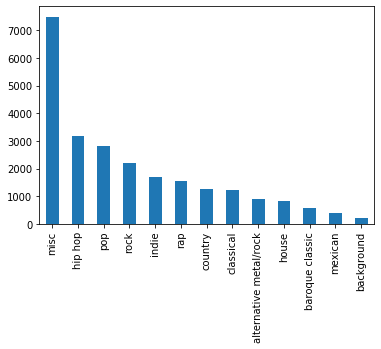

In [15]:
# visualize data
plot = dat["genre_agg"].value_counts().plot(kind="bar")

### User Selection

In [16]:
def drop_dupes_user(df, user):
    '''
    Remaining duplicates in our dataset need do be removed depending on the user that subsequent analysis 
    is based on. In the following code chunks, a user is selected and all duplicates from the user-unspecific 
    data are removed.
    '''
    
    # assign dropping order
    for i in range(len(df["df_label"])):
        # labeled song
        if (df.loc[i, "df_label"] == user) & (np.isnan(df.loc[i, "Rating01"]) != True):
            df.loc[i, "drop_prio"] = 3
        # user song
        elif (df.loc[i, "df_label"] == user) & (np.isnan(df.loc[i, "Rating01"]) == True):
            df.loc[i, "drop_prio"] = 2
        # user unspecific song
        elif (df.loc[i, "df_label"] != user):
            df.loc[i, "drop_prio"] = 1
    # sort values in dropping order
    df = df.sort_values("drop_prio")
    # drop duplicates, keeping the last ones
    df = df.drop_duplicates(subset = ["uri"], keep = "last")
    # resort values
    df = df.sort_index()
    # reset index
    df = df.reset_index(drop=True)
    # drop drop_prio column
    df.drop(columns = ["drop_prio"], inplace = True)
    # return results
    return df

In [17]:
dat = drop_dupes_user(dat, "user4")

### Get Dummies

In [18]:
def dummy_code_categoricals(df):
    '''
    Takes df and returns df with dummy coded categorical variables.
    Explicit with 1 = explicit, 0 = not.
    Converts recently_played, saved_tracks, and top_tracks into 1 = yes and 0 = no
    Album label category with 'small label' as reference class. 
    '''
    
    df_dummies = pd.get_dummies(df['album_label_category'], prefix = 'album')
    df_dummies.reset_index(drop = True, inplace = True)
    df.reset_index(drop = True, inplace = True)
    df = pd.concat([df, df_dummies], axis = 1).drop(['album_label_category', 'album_small_label'], axis = 1)
    
    df_dummies = pd.get_dummies(df['genre_agg'], prefix = 'genre')
    df_dummies.reset_index(drop = True, inplace = True)
    df.reset_index(drop = True, inplace = True)
    df = pd.concat([df, df_dummies], axis = 1).drop(['genre_agg', 'genre_misc'], axis = 1)
    
    df['explicit'] = df['explicit']*1
    
    for i in range(len(df["name"])):
        if (df.loc[i, "recently_played"] == "True"):
            df.loc[i, "recently_played"] = 1
        elif (df.loc[i, "recently_played"] == "False"):
            df.loc[i, "recently_played"] = 0
    for i in range(len(df["name"])):
        if (df.loc[i, "saved_tracks"] == "True"):
            df.loc[i, "saved_tracks"] = 1
        elif (df.loc[i, "saved_tracks"] == "False"):
            df.loc[i, "saved_tracks"] = 0
    for i in range(len(df["name"])):
        if (df.loc[i, "top_tracks"] == "True"):
            df.loc[i, "top_tracks"] = 1
        elif (df.loc[i, "top_tracks"] == "False"):
            df.loc[i, "top_tracks"] = 0
            
    df[["recently_played", "saved_tracks", "top_tracks"]] = df[["recently_played", 
                                                                "saved_tracks", 
                                                                "top_tracks"]].apply(pd.to_numeric, errors="coerce")

    return df

In [19]:
dat = dummy_code_categoricals(dat)
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21445 entries, 0 to 21444
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         21445 non-null  object 
 1   uri                          21445 non-null  object 
 2   album_uri                    21445 non-null  object 
 3   album_name                   21445 non-null  object 
 4   album_popularity             21445 non-null  int64  
 5   artist_uri                   21445 non-null  object 
 6   artist_name                  21445 non-null  object 
 7   artist_popularity            21445 non-null  int64  
 8   artist_followers             21445 non-null  int64  
 9   explicit                     21445 non-null  int64  
 10  popularity                   21445 non-null  int64  
 11  track_number                 21445 non-null  int64  
 12  acousticness                 21445 non-null  float64
 13  danceability    

In [20]:
# this final step is optional
# dat.to_csv("01_Data/spotify_dat.csv")